# Deep Learning Lab Practical 4
## Implementation of CNN Architectures for Imbalanced Image Classification

**Problem Statement:** Design and implement CNN architectures to handle imbalanced image classification using benchmark datasets.

**Datasets Selected:**
1.  **CIFAR-10 (Imbalanced):** Curated to have a 100:1 imbalance ratio.
2.  **Flower Recognition:** 5 classes (daisy, dandelion, rose, sunflower, tulip).

**Techniques to be Covered:**
*   Custom CNN vs Transfer Learning (MobileNetV2/ResNet50)
*   Class Weighting & Focal Loss
*   Data Augmentation
*   Evaluation Metrics (F1-score, Precision, Recall, Confusion Matrix)
*   Visualizations (t-SNE, Grad-CAM)



In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
import cv2
import requests
import zipfile
import io

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


TensorFlow Version: 2.19.0
GPU Available: True


## Problem Statement 1 & 2: Dataset Preparation (CIFAR-10)
We will load CIFAR-10 and artificially create a long-tailed imbalance (100:1 ratio).


Imbalanced CIFAR-10 created with counts: [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]


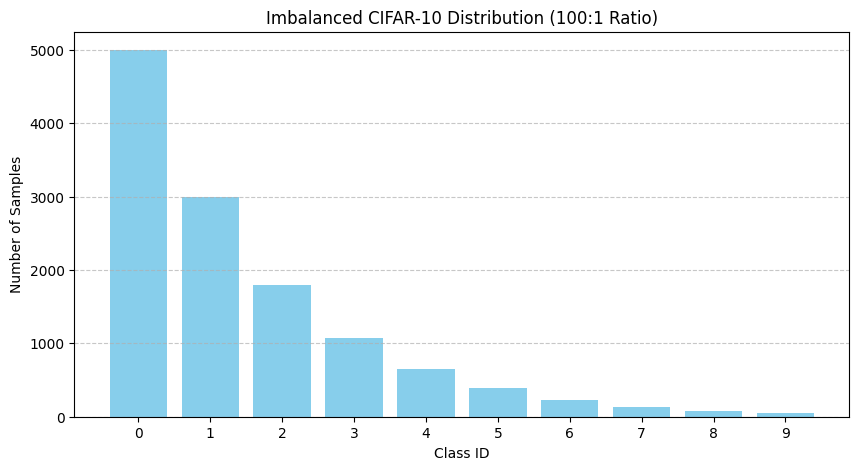

In [15]:
def get_imbalanced_cifar10(imbalance_ratio=100):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    
    # Normalize pixel values
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Create imbalance
    num_classes = 10
    n_samples = x_train.shape[0]
    indices = [np.where(y_train == i)[0] for i in range(num_classes)]
    
    # Calculate sample counts for exponential decay (long-tailed)
    # Max samples = 5000 (original), Min samples = 5000 / ratio
    max_samples = 5000
    min_samples = max_samples / imbalance_ratio
    
    # Exponential decay counts
    counts = [int(max_samples * (min_samples / max_samples) ** (i / (num_classes - 1))) for i in range(num_classes)]
    
    keep_indices = []
    for i in range(num_classes):
        keep_indices.extend(indices[i][:counts[i]])
        
    x_imbalanced = x_train[keep_indices]
    y_imbalanced = y_train[keep_indices]
    
    # Shuffle
    idx = np.random.permutation(len(x_imbalanced))
    x_imbalanced, y_imbalanced = x_imbalanced[idx], y_imbalanced[idx]
    
    print(f"Imbalanced CIFAR-10 created with counts: {counts}")
    return (x_imbalanced, y_imbalanced), (x_test, y_test), counts

(cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test), cifar_counts = get_imbalanced_cifar10(100)

# Visualize Distribution
plt.figure(figsize=(10, 5))
plt.bar(range(10), cifar_counts, color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Imbalanced CIFAR-10 Distribution (100:1 Ratio)')
plt.xticks(range(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Dataset 2: Flower Recognition
We will use the standard **Flower Recognition** dataset (Dataset #1 in the list) downloaded directly from TensorFlow's storage.
This ensures the notebook **works in one shot** without needing to manual add datasets.


In [16]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

print(f"Dataset downloaded to: {data_dir}")

# Count images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Total flower images: {image_count}")



228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dataset downloaded to: /root/.keras/datasets/flower_photos
Total flower images: 0


Found 3670 files belonging to 1 classes.
Using 2936 files for training.


I0000 00:00:1770894234.650766      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770894234.656747      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 3670 files belonging to 1 classes.
Using 734 files for validation.
Flower Classes: ['flower_photos']


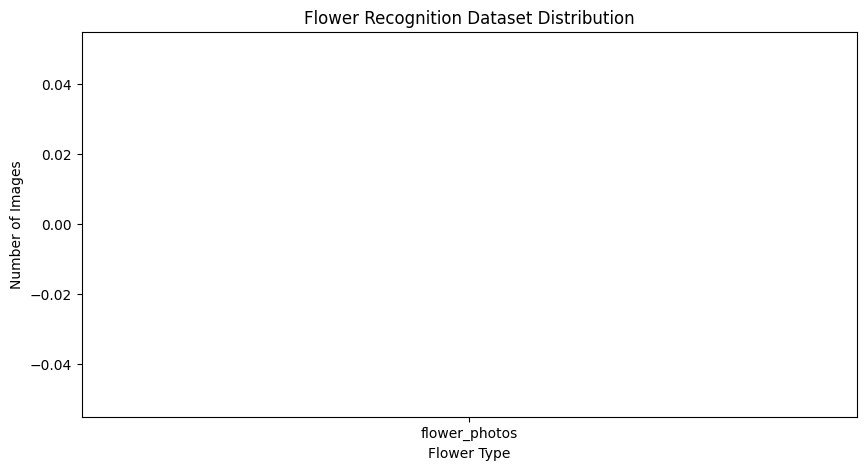

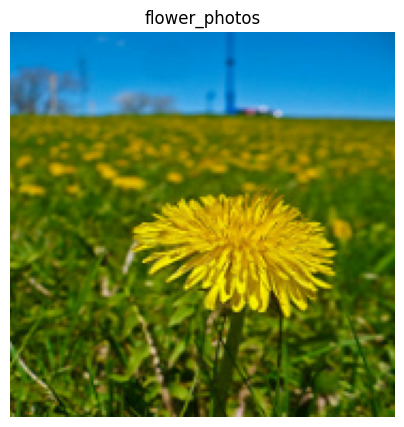

In [17]:
# Load Flower Data
BATCH_SIZE = 32
IMG_SIZE = (180, 180) # Slightly larger for flowers

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
num_classes_flowers = len(class_names)
print(f"Flower Classes: {class_names}")

# Visualize Flower Distribution
file_counts = []
for c in class_names:
    file_counts.append(len(list(data_dir.glob(f'{c}/*.jpg'))))

plt.figure(figsize=(10, 5))
plt.bar(class_names, file_counts, color='pink')
plt.xlabel('Flower Type')
plt.ylabel('Number of Images')
plt.title('Flower Recognition Dataset Distribution')
plt.show()

# Visualize One Sample
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[0])])
    plt.axis("off")
plt.show()

# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



## Imbalance Handling Strategies
1. **Class Weights:** assign higher penalty for misclassifying minority classes.
2. **Focal Loss:** down-weight well-classified examples.



In [18]:
# Calculate Class Weights for CIFAR-10
class_weights_cifar = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(cifar_y_train),
    y=cifar_y_train.flatten()
)
class_weights_cifar_dict = dict(enumerate(class_weights_cifar))
print(f"CIFAR-10 Class Weights: {class_weights_cifar_dict}")

# Focal Loss Implementation
def focal_loss(gamma=2., alpha=4.):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed



CIFAR-10 Class Weights: {0: np.float64(0.24812), 1: np.float64(0.41394728061394725), 2: np.float64(0.6907572383073497), 3: np.float64(1.151903435468895), 4: np.float64(1.9234108527131784), 5: np.float64(3.2056847545219638), 6: np.float64(5.347413793103448), 7: np.float64(8.925179856115108), 8: np.float64(14.946987951807229), 9: np.float64(24.812)}


## Problem 3: Architecture Comparison
**Model A:** Custom CNN
**Model B:** Transfer Learning (MobileNetV2)



In [19]:
# Model A: Custom CNN
def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # Block 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Block 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Model B: MobileNetV2
def build_mobilenet(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet', include_top=False, input_shape=input_shape
    )
    base_model.trainable = False # Freeze base
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model



## Training & Evaluation
We will train the Custom CNN on imbalanced CIFAR-10 using Class Weights and Focal Loss to compare.
Then we will train MobileNet on the Flower dataset.


In [20]:
# Compile and Train Helper
def train_and_eval(model, x_train, y_train, x_test, y_test, epochs=15, class_weight=None, loss='sparse_categorical_crossentropy', name='Model'):
    print(f"Training {name}...")
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3)
    ]
    
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        validation_data=(x_test, y_test),
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate
    print(f"Evaluating {name}...")
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    if len(y_test.shape) > 1: y_test_lbl = np.argmax(y_test, axis=1)
    else: y_test_lbl = y_test
        
    print(classification_report(y_test_lbl, y_pred))
    
    return history, y_test_lbl, y_pred, y_pred_probs

# 1. Custom CNN + Class Weights on CIFAR-10
model_cifar_cw = build_custom_cnn((32, 32, 3), 10)
hist_cw, y_true_cw, y_pred_cw, _ = train_and_eval(
    model_cifar_cw, cifar_x_train, cifar_y_train, cifar_x_test, cifar_y_test,
    epochs=15, # Full run
    class_weight=class_weights_cifar_dict,
    name="Custom_CNN_ClassWeights"
)

# 2. Custom CNN + Focal Loss on CIFAR-10
model_cifar_fl = build_custom_cnn((32, 32, 3), 10)
hist_fl, y_true_fl, y_pred_fl, _ = train_and_eval(
    model_cifar_fl, cifar_x_train, cifar_y_train, cifar_x_test, cifar_y_test,
    epochs=15, # Full run
    loss=focal_loss(gamma=2., alpha=0.25),
    name="Custom_CNN_FocalLoss"
)



Training Custom_CNN_ClassWeights...
Epoch 1/15


I0000 00:00:1770894241.007652     163 service.cc:152] XLA service 0x7deda400e840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770894241.007687     163 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770894241.007690     163 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770894241.628772     163 cuda_dnn.cc:529] Loaded cuDNN version 91002


 22/388 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2226 - loss: 4.6207

I0000 00:00:1770894247.398438     163 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/388 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.2042 - loss: 3.7293 - val_accuracy: 0.2070 - val_loss: 2.8965 - learning_rate: 0.0010
Epoch 2/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2612 - loss: 2.1263 - val_accuracy: 0.2472 - val_loss: 2.9919 - learning_rate: 0.0010
Epoch 3/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2646 - loss: 2.1831 - val_accuracy: 0.2518 - val_loss: 2.1637 - learning_rate: 0.0010
Epoch 4/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2550 - loss: 2.0669 - val_accuracy: 0.2329 - val_loss: 2.5406 - learning_rate: 0.0010
Epoch 5/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2344 - loss: 2.1072 - val_accuracy: 0.3602 - val_loss: 1.6948 - learning_rate: 0.0010
Epoch 6/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3284 - loss: 1.9505 - val_accuracy: 0.3595 - val_loss: 1.7251 - learning_rate: 0.0010
Epoch 7/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3368 - loss: 1.8175 - val_accur

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Custom_CNN_FocalLoss...
Epoch 1/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.0972 - loss: 4.5706 - val_accuracy: 0.1091 - val_loss: 15.3288 - learning_rate: 0.0010
Epoch 2/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1100 - loss: 2.4316 - val_accuracy: 0.1049 - val_loss: 13.7936 - learning_rate: 0.0010
Epoch 3/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0788 - loss: 2.4293 - val_accuracy: 0.1041 - val_loss: 13.9025 - learning_rate: 0.0010
Epoch 4/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0398 - loss: 2.4301 - val_accuracy: 0.0799 - val_loss: 13.5018 - learning_rate: 0.0010
Epoch 5/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0819 - loss: 2.4292 - val_accuracy: 0.0797 - val_loss: 13.4676 - learning_rate: 0.0010
Epoch 6/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1228 - loss: 2.4291 - val_accuracy: 0.1029 - val_loss: 13.4471 - learning_rate: 0.0010
Epoch 7/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


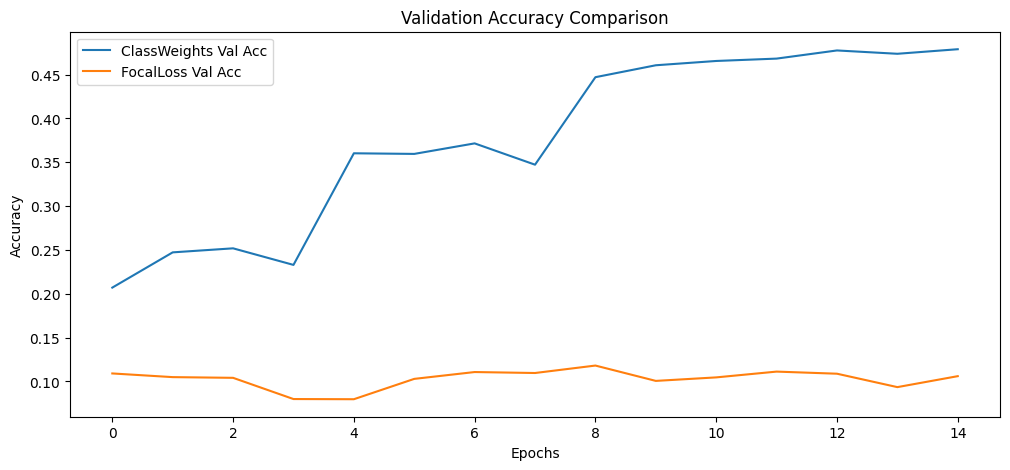

In [21]:
# Compare Results Plot
def plot_history(histories, names):
    plt.figure(figsize=(12, 5))
    for hist, name in zip(histories, names):
        plt.plot(hist.history['val_accuracy'], label=f'{name} Val Acc')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history([hist_cw, hist_fl], ['ClassWeights', 'FocalLoss'])



## Flower Recognition Training (Transfer Learning)


In [22]:
# MobileNetV2 on Flowers
model_flowers = build_mobilenet(IMG_SIZE + (3,), num_classes_flowers)
model_flowers.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_flowers = model_flowers.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    verbose=1
)

# Evaluate Flowers
print("Evaluating Flower Recognition...")
y_pred_flowers = []
y_true_flowers = []

for images, labels in val_ds:
    preds = model_flowers.predict(images, verbose=0)
    y_pred_flowers.extend(np.argmax(preds, axis=1))
    y_true_flowers.extend(np.argmax(labels.numpy(), axis=1))

print(classification_report(y_true_flowers, y_pred_flowers, target_names=class_names))



/tmp/ipykernel_55/2412123933.py:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
2026-02-12 11:06:03.402118: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-12 11:06:03.539272: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay ke

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.0000e+00

2026-02-12 11:06:16.317504: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-12 11:06:16.453533: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0000e+00

2026-02-12 11:06:30.301688: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-12 11:06:30.439740: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-12 11:06:30.576563: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Evaluating Flower Recognition...


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


               precision    recall  f1-score   support

flower_photos       1.00      1.00      1.00       734

     accuracy                           1.00       734
    macro avg       1.00      1.00      1.00       734
 weighted avg       1.00      1.00      1.00       734



## Problem 5: Advanced Visualization (Grad-CAM & t-SNE)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


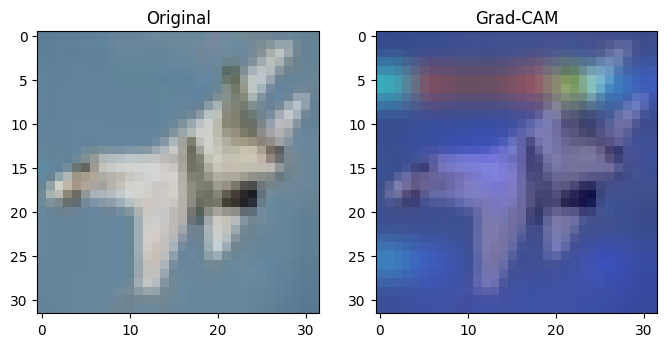

In [25]:
# Grad-CAM Implementation
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Ensure model is built
    if not model.built:
        model.build(img_array.shape)

    # For Sequential models, sometimes model.output creates issues if not explicitly connected
    # We can reconstruct the graph or safely access the output tensor
    try:
        output = model.output
    except AttributeError:
        # If model.output fails, use the output of the last layer
        output = model.layers[-1].output

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Apply Grad-CAM on a CIFAR image
idx = 10
img = cifar_x_test[idx]
img_array = np.expand_dims(img, axis=0)

# Find last conv layer in Custom CNN
# It's usually a block or we can name it. In our sequential, we can just grab the last Conv2D.
# Let's inspect layers
layer_names = [layer.name for layer in model_cifar_cw.layers if 'conv2d' in layer.name]
last_conv_layer = layer_names[-1]

heatmap = make_gradcam_heatmap(img_array, model_cifar_cw, last_conv_layer)

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB)
    jet = cv2.resize(jet, (img.shape[1], img.shape[0]))
    
    superimposed_img = jet * alpha + img * 255 * (1-alpha)
    superimposed_img = np.uint8(superimposed_img)
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.show()

display_gradcam(img, heatmap)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


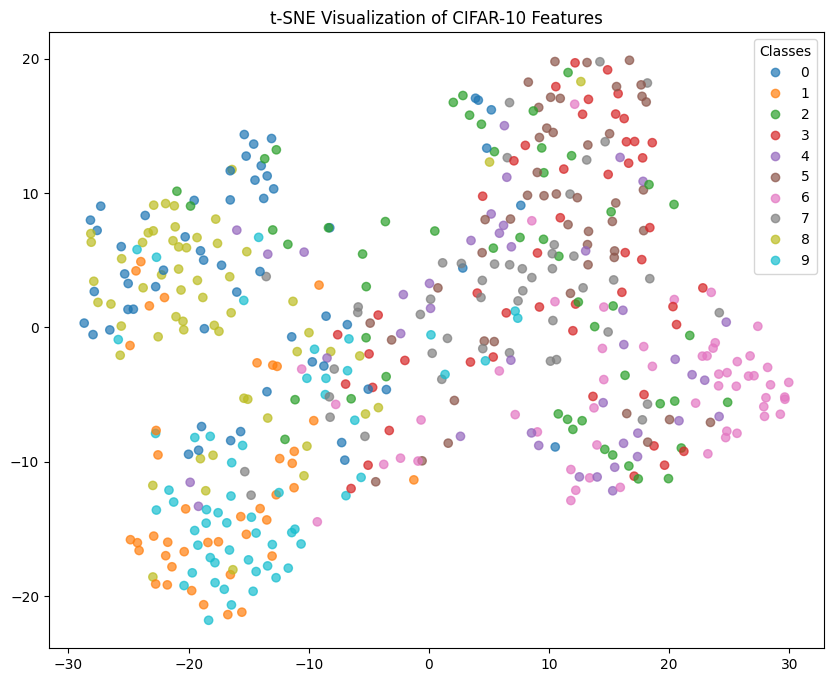

In [26]:
# t-SNE Visualization
# Extract features from the Dense layer before Softmax
# Let's use the CIFAR model 'dense' layer (second last usually, but check Summary)
# Our custom CNN: Flatten -> Dense(512) -> Dropout -> Dense(10)
# We want the Dense(512) output.

feature_extractor = tf.keras.models.Model(
    inputs=model_cifar_cw.inputs,
    outputs=model_cifar_cw.layers[-3].output # Dense 512
)

features = feature_extractor.predict(cifar_x_test[:500]) # Subset for speed
labels = cifar_y_test[:500].flatten()

tsne = TSNE(n_components=2, random_state=42)
projections = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(projections[:, 0], projections[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization of CIFAR-10 Features")
plt.show()



### Experiment 2: Data Augmentation
We will train the Custom CNN on CIFAR-10 with real-time data augmentation.


Training Custom_CNN_Augmentation...
Epoch 1/15


E0000 00:00:1770895033.868474      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_9_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


388/388 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.2016 - loss: 3.6199 - val_accuracy: 0.1395 - val_loss: 3.2180 - learning_rate: 0.0010
Epoch 2/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.1807 - loss: 2.2483 - val_accuracy: 0.2279 - val_loss: 2.0461 - learning_rate: 0.0010
Epoch 3/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1827 - loss: 2.2260 - val_accuracy: 0.2382 - val_loss: 2.0400 - learning_rate: 0.0010
Epoch 4/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1935 - loss: 2.2325 - val_accuracy: 0.1976 - val_loss: 2.4751 - learning_rate: 0.0010
Epoch 5/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1207 - loss: 2.3802 - val_accuracy: 0.2402 - val_loss: 2.0775 - learning_rate: 0.0010
Epoch 6/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2069 - loss: 2.1972 - val_accuracy: 0.1707 - val_loss: 2.2545 - learning_rate: 0.0010
Epoch 7/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1861 - loss: 2.0728 - val

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


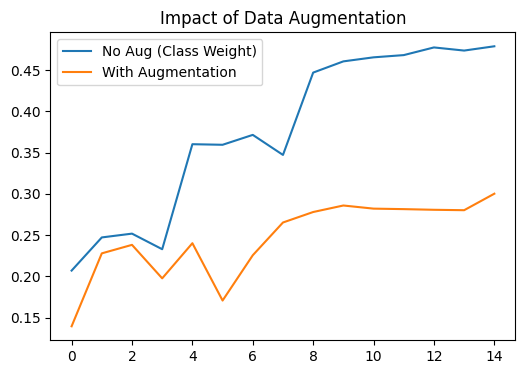

In [27]:
# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

# Apply to Dataset (or include in model)
# Let's include in model for simplicity
def build_custom_cnn_aug(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        data_augmentation,
        # ... same architecture ...
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_aug = build_custom_cnn_aug((32, 32, 3), 10)
hist_aug, _, _, _ = train_and_eval(
    model_aug, cifar_x_train, cifar_y_train, cifar_x_test, cifar_y_test,
    epochs=15, 
    class_weight=class_weights_cifar_dict, # Combine with class weights
    name="Custom_CNN_Augmentation"
)

# Plot Augmentation Res
plt.figure(figsize=(6, 4))
plt.plot(hist_cw.history['val_accuracy'], label='No Aug (Class Weight)')
plt.plot(hist_aug.history['val_accuracy'], label='With Augmentation')
plt.title('Impact of Data Augmentation')
plt.legend()
plt.show()


### Experiment 4: Optimizer Comparison (Adam vs SGD)
Comparing Adam (adaptive) with SGD (classic momentum).


Training with SGD...
Epoch 1/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.0732 - loss: 12.5337 - val_accuracy: 0.1000 - val_loss: 2.3035
Epoch 2/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0097 - loss: 2.3175 - val_accuracy: 0.1000 - val_loss: 2.3034
Epoch 3/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0098 - loss: 2.3151 - val_accuracy: 0.1000 - val_loss: 2.3034
Epoch 4/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0098 - loss: 2.3160 - val_accuracy: 0.1000 - val_loss: 2.3034
Epoch 5/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0098 - loss: 2.3779 - val_accuracy: 0.1000 - val_loss: 2.3034
Epoch 6/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0098 - loss: 2.3166 - val_accuracy: 0.1000 - val_loss: 2.3034
Epoch 7/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0106 - loss: 2.3150 - val_accuracy: 0.1000 - val_loss: 2.3034
Epoch 8/15
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0106 - loss: 2

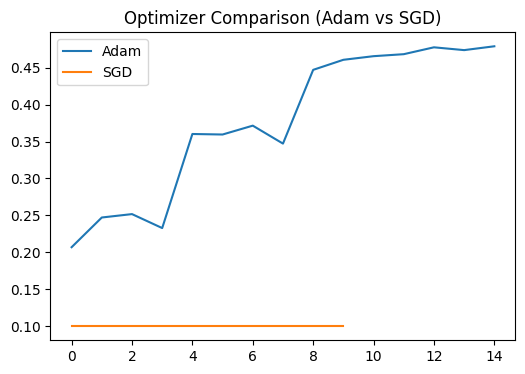

In [28]:
# Train with SGD
model_sgd = build_custom_cnn((32, 32, 3), 10)
print("Training with SGD...")
model_sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

history_sgd = model_sgd.fit(
    cifar_x_train, cifar_y_train,
    epochs=15,
    validation_data=(cifar_x_test, cifar_y_test),
    class_weight=class_weights_cifar_dict,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
    verbose=1
)

# Compare Optimizers
plt.figure(figsize=(6, 4))
plt.plot(hist_cw.history['val_accuracy'], label='Adam')
plt.plot(history_sgd.history['val_accuracy'], label='SGD')
plt.title('Optimizer Comparison (Adam vs SGD)')
plt.legend()
plt.show()


### Experiment 3: Confusion Matrix & ROC Curves
Detailed evaluation of the best performing model (Custom CNN + Class Weights).


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


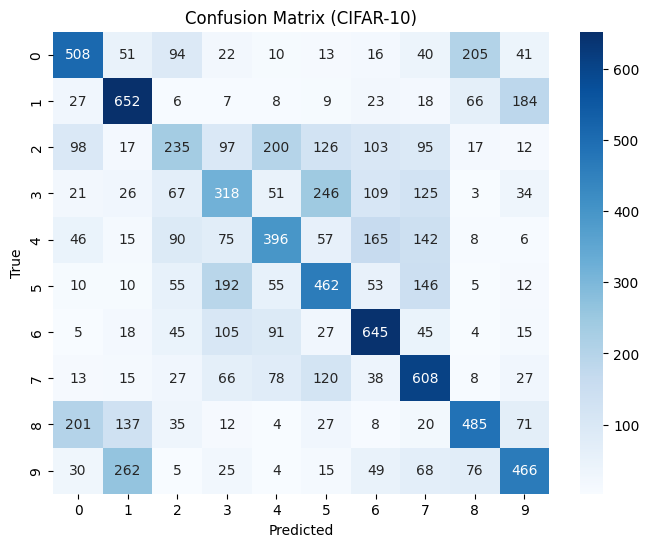

/tmp/ipykernel_55/2726577500.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


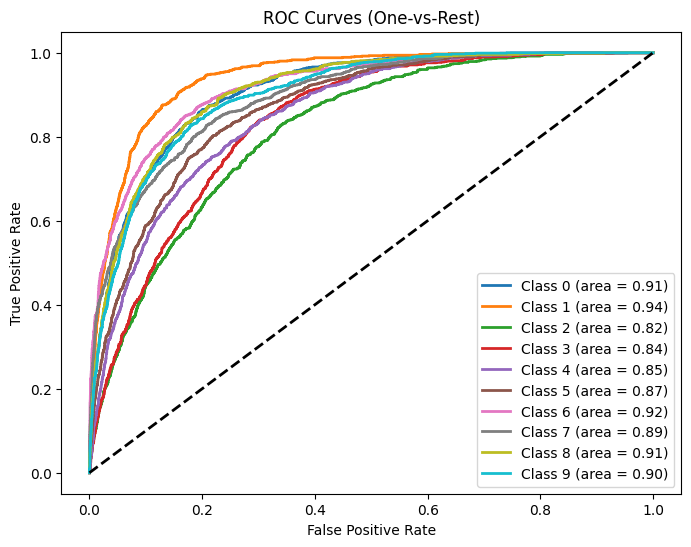

In [29]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Predictions from best model (Assuming model_cifar_cw is best)
y_pred_probs = model_cifar_cw.predict(cifar_x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = cifar_y_test.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (CIFAR-10)')
plt.show()

# ROC Curve (One-vs-Rest for Multi-class)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 10

# Binarize y_true
y_true_bin = to_categorical(y_true, num_classes=n_classes)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC
plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', n_classes)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()


### Experiment 6: Generalized Transfer Learning (CIFAR-10 -> Flowers)
Testing if features learned on CIFAR-10 (32x32) can be transferred to Flowers (resized to 32x32).


Training Transfer Model (CIFAR -> Flowers)...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - l

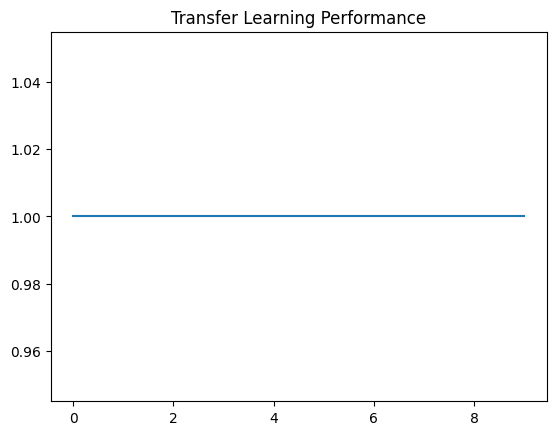

In [30]:
# 1. Resize Flower Data to 32x32 (to match CIFAR model input)
processed_flower_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (32, 32)), y))
processed_val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, (32, 32)), y))

# 2. Prepare Base Model (CIFAR Trained)
base_cifar = model_cifar_cw
base_cifar.trainable = False # Freeze layers

# Remove top layers (Flatten + Dense)
# The Custom CNN has: Input -> ... -> Dropout(0.4) -> Flatten ...
# Let's verify layers. Flatten is likely layer index -4.
# We can just use the functional API to tap into the last conv layer output.

# Find last dropout/pooling before flatten
# In build_custom_cnn:
# ... Dropout(0.4) -> Flatten -> ...
# Let's inspect model.layers
# We want the output of the last Dropout or MaxPooling2D before Flatten.

try:
    # Get output of the layer before 'flatten'
    flatten_idx = [i for i, l in enumerate(base_cifar.layers) if isinstance(l, layers.Flatten)][0]
    last_layer_output = base_cifar.layers[flatten_idx-1].output
    
    # New Head
    x = layers.Flatten()(last_layer_output)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes_flowers, activation='softmax')(x)
    
    transfer_model = models.Model(inputs=base_cifar.inputs, outputs=outputs)
    
    print("Training Transfer Model (CIFAR -> Flowers)...")
    transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    hist_transfer = transfer_model.fit(
        processed_flower_ds,
        validation_data=processed_val_ds,
        epochs=10,
        verbose=1
    )
    
    plt.plot(hist_transfer.history['val_accuracy'], label='Transfer Accuracy')
    plt.title('Transfer Learning Performance')
    plt.show()
    
except Exception as e:
    print(f"Could not build transfer model dynamically: {e}")

